# Conexão com banco

In [8]:
import pandas as pd
import psycopg2
from IPython.display import display


host = "silly.db.elephantsql.com"
port = "5432"
database = "ljppladj"
user = "ljppladj"
password = "JFgtpa3EjnB6zOJ75ejGn_gUOl8-dy3j"

try:
    conn = psycopg2.connect(
        host=host,
        port=port,
        database=database,
        user=user,
        password=password
    )
    print("Conexão bem-sucedida!")
except Exception as e:
    print(f"Erro ao conectar: {e}")


Conexão bem-sucedida!


# Populando dataframe

In [9]:
# Crie um cursor para executar comandos SQL no banco de dados
cursor = conn.cursor()

# Execute a consulta SQL para juntar as tabelas e obter os dados desejados
cursor.execute("""
  SELECT 
        candidates.cnd_id, 
        candidates.cnd_name, 
        candidates.cnd_email, 
        candidates.cnd_current_profession, 
        candidates.cnd_experience, 
        skl_skill.skl_name as skill,
        knw_knowledge.knw_name as knowledge,
        att_attitude.att_name as attitude
    FROM candidates
    LEFT JOIN candidate_skill ON candidates.cnd_id = candidate_skill.cnd_id
    LEFT JOIN skl_skill ON candidate_skill.knw_id = skl_skill.skl_id
    LEFT JOIN knw_knowledge ON skl_skill.skl_id = knw_knowledge.knw_id
    LEFT JOIN candidate_attitude ON candidates.cnd_id = candidate_attitude.cnd_id
    LEFT JOIN att_attitude ON candidate_attitude.knw_id = att_attitude.att_id

""")

df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

# Remover duplicatas mantendo apenas as colunas relevantes
df_skills = df[['cnd_id', 'cnd_name', 'cnd_email' ,'cnd_experience', 'skill']].drop_duplicates()
df_knowledge = df[['cnd_id', 'cnd_name', 'cnd_experience', 'knowledge']].drop_duplicates()
df_attitude = df[['cnd_id', 'cnd_name', 'cnd_experience', 'attitude']].drop_duplicates()

# display(df_skills)
# display(df_knowledge)
# display(df_attitude)

cursor.close()

# Classificação de dados

In [10]:
desenvolvedor = {
    'profissao': 'Desenvolvedor Back-End',
    'habilidades': [
        'Python', 
        'Java', 
        'Node.js', 
        'MySQL',
        'PostgreSQL'
    ],
    'conhecimentos': [
        'Manipulação de Dados',
        'Conhecimento em SQL',
        'Testes Automatizados'
    ],
    'atitudes': [
        'Lógica de Programação',
        'Empatia',
        'Criatividade',
        'Resiliência',
        
    ]
}


habilidades = desenvolvedor['habilidades']
conhecimentos = desenvolvedor['conhecimentos']
atitudes = desenvolvedor['atitudes']

df_skills['tem_habilidade'] = 0
df_knowledge['tem_conhecimento'] = 0
df_attitude['tem_atitude'] = 0

# Confere se a o item do CHA existe nos candidatos, se sim retorna 1, caso não, retorna 0
# Para as habilidades
for habilidade in habilidades:
    df_skills['tem_habilidade'] = (df_skills['tem_habilidade'] | df_skills['skill'].fillna('').str.contains(habilidade, case=False)).astype(int)

# Para os conhecimentos
for conhecimento in conhecimentos:
    df_knowledge['tem_conhecimento'] = (df_knowledge['tem_conhecimento'] + 2 * df_knowledge['knowledge'].fillna('').str.contains(conhecimento, case=False)).astype(int)

# Para as atitudes
for atitude in atitudes:
    df_attitude['tem_atitude'] = (df_attitude['tem_atitude'] | df_attitude['attitude'].fillna('').str.contains(atitude, case=False)).astype(int)


# display(df_skills)
display(df_knowledge)
# display(df_attitude)


,cnd_id,cnd_name,cnd_experience,knowledge,tem_conhecimento
0,1,João,0,None,0
100,1,João,0,Design Patterns,0
110,1,João,0,Testes Automatizados,2
120,2,Maria Oliveira,0,None,0
220,2,Maria Oliveira,0,Design Patterns,0
230,2,Maria Oliveira,0,Testes Automatizados,2
240,3,Rafael Pereira,0,None,0
340,3,Rafael Pereira,0,Design Patterns,0
350,3,Rafael Pereira,0,Testes Automatizados,2
360,4,Luana Santos,0,None,0


# Mesclando dados

In [11]:
# Somando as contagens de habilidades, conhecimentos e atitudes
df_skills['num_habilidades'] = df_skills.groupby('cnd_id')['tem_habilidade'].transform('sum')
df_attitude['num_atitudes'] = df_attitude.groupby('cnd_id')['tem_atitude'].transform('sum')
df_knowledge['num_conhecimentos'] = df_knowledge.groupby('cnd_id')['tem_conhecimento'].transform('sum')

df_final = df_skills.copy()

df_final['pontos_cha'] = df_skills['num_habilidades'] + df_attitude['num_atitudes'] + df_knowledge['num_conhecimentos']

df_final['num_atitudes'] = df_attitude['num_atitudes']
df_final['num_conhecimentos'] = df_knowledge['num_conhecimentos']
df_final = df_final.dropna(subset=['pontos_cha'])

# Remover as colunas 'skill' e 'cnd_experience'
df_final = df_final.drop(['skill', 'cnd_experience'], axis=1)

display(df_final)


,cnd_id,cnd_name,cnd_email,tem_habilidade,num_habilidades,pontos_cha,num_atitudes,num_conhecimentos
0,1,João,joao@email.com,0,3,6.0,1.0,2.0
120,2,Maria Oliveira,maria.oliveira456@email.com,0,3,6.0,1.0,2.0
240,3,Rafael Pereira,rafael.pereira789@email.com,0,3,6.0,1.0,2.0
360,4,Luana Santos,luana.santos123@email.com,0,3,6.0,1.0,2.0
480,5,Felipe Oliveira,felipe.oliveira456@email.com,0,3,6.0,1.0,2.0
600,6,Gabriel Almeida,gabriel.almeida123@email.com,0,3,6.0,1.0,2.0
720,7,Luana Santos,luana.santos123@email.com,1,3,3.0,0.0,0.0
732,8,Ricardo Alves Pereira,ricardo.alves.pereira789@email.com,0,1,1.0,0.0,0.0
744,9,Beatriz Gonçalves,beatriz.goncalves789@email.com,1,2,2.0,0.0,0.0
753,10,Carlos Ferreira,carlos.ferreira@email.com,0,0,0.0,0.0,0.0


# Aplicando Árvore de decisão de regressão

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# Defina X e y
X = df_final[['cnd_id', 'tem_habilidade', 'num_habilidades',  'num_atitudes', 'num_conhecimentos']]
y = df_final['pontos_cha']

# Crie o modelo de Árvore de Decisão para Regressão
dt_regressor = DecisionTreeRegressor(random_state=42)

# Realize a validação cruzada com 5 folds (k=5), dividi os dados em 5 partes
scores = cross_val_score(dt_regressor, X, y, cv=5, scoring='neg_mean_squared_error')

# A função cross_val_score retorna os scores negativos, então tomamos a média e multiplicamos por -1
mse_scores = -scores

# Calcule o MSE médio
#Erro Quadrático Médio , é utilizada para avaliar a qualidade de um modelo de regressão. 
# Quanto menor o valor do MSE, melhor o modelo 
average_mse = mse_scores.mean()

# Exiba os resultados
print(f'MSE Scores: {mse_scores}')
print(f'Média MSE: {average_mse}')




MSE Scores: [0.  3.5 0.5 1.  0. ]
Média MSE: 1.0


# Mapa de calor

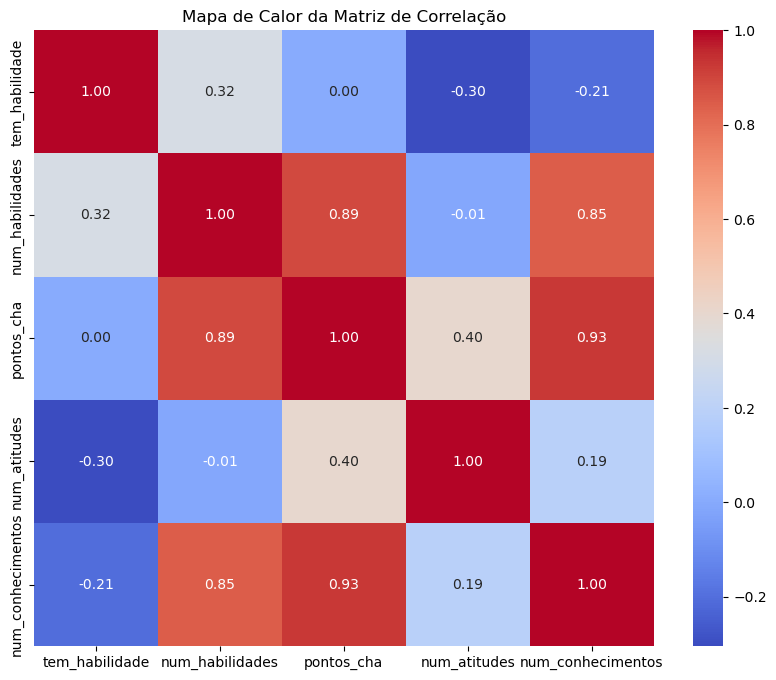

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


# Copie o DataFrame original para evitar modificar o DataFrame original
df_map = df_final.copy()

# Use o método drop para remover as colunas desejadas
colunas_para_remover = ['cnd_name', 'cnd_email', 'cnd_id']
df_map = df_map.drop(colunas_para_remover, axis=1)

# Calcule a matriz de correlação
correlation_matrix = df_map.corr()

# Crie o mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Calor da Matriz de Correlação")
plt.show()


# Treinamento dos dados

In [14]:
dt_regressor.fit(X, y)

X_novos = df_final[['cnd_id', 'tem_habilidade', 'num_habilidades', 'num_atitudes', 'num_conhecimentos']]

# Substitua X_novos pelos dados que você deseja fazer previsões
previsoes = dt_regressor.predict(X_novos)

# Crie um DataFrame com as previsões
resultados = pd.DataFrame({'pontuacao': previsoes})

# Ordene o DataFrame em ordem decrescente
resultados = resultados.sort_values(by='pontuacao', ascending=False)

colunas_para_remover = ['tem_habilidade', 'pontos_cha', 'num_habilidades', 'num_atitudes', 'num_conhecimentos']
df_final = df_final.drop(colunas_para_remover, axis=1)

df_final['pontuacao'] = previsoes

# Ordenando por pontuação
df_final = df_final.sort_values(by='pontuacao', ascending=False)
melhores_candidatos = df_final.head(10)

display(melhores_candidatos)

,cnd_id,cnd_name,cnd_email,pontuacao
0,1,João,joao@email.com,6.0
240,3,Rafael Pereira,rafael.pereira789@email.com,6.0
360,4,Luana Santos,luana.santos123@email.com,6.0
480,5,Felipe Oliveira,felipe.oliveira456@email.com,6.0
600,6,Gabriel Almeida,gabriel.almeida123@email.com,6.0
120,2,Maria Oliveira,maria.oliveira456@email.com,6.0
720,7,Luana Santos,luana.santos123@email.com,3.0
877,17,Luiz Carlos Ferreira,luiz.ferreira@email.com,2.0
937,20,Fernanda Costa Oliveira,fernanda.costa.oliveira@email.com,2.0
917,19,Rodrigo Alves Pereira,rodrigo.alves.pereira@email.com,2.0


# Enviando por requisição

In [18]:
class Candidato:
    def __init__(self, cnd_id, cnd_name, cnd_email, pontuacao):
        self.cnd_id = cnd_id
        self.cnd_name = cnd_name
        self.cnd_email = cnd_email
        self.pontuacao = pontuacao

# Criar uma lista de objetos Candidato
lista_candidatos = [Candidato(**row) for index, row in melhores_candidatos.iterrows()]
# Exibir os objetos Candidato
for candidato in lista_candidatos:
    print(f"Candidato {candidato.cnd_name}: {candidato.pontuacao} pontos")

Candidato João: 5.0 pontos
Candidato Rafael Pereira: 5.0 pontos
Candidato Luana Santos: 5.0 pontos
Candidato Felipe Oliveira: 5.0 pontos
Candidato Gabriel Almeida: 5.0 pontos
Candidato Maria Oliveira: 5.0 pontos
Candidato Luana Santos: 3.0 pontos
Candidato Luiz Carlos Ferreira: 2.0 pontos
Candidato Fernanda Costa Oliveira: 2.0 pontos
Candidato Rodrigo Alves Pereira: 2.0 pontos
